<a href="https://colab.research.google.com/github/mateusribeirocampos/diollm/blob/main/Copy_of_Facial_recognition_using_Keras_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de reconhecimento facial

Importação dos frameworks e bibliotecas


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import random
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

warnings.filterwarnings('ignore')
%matplotlib inline

## Carregar o dataset



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Divisão das imagens para treino e teste

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminhos
input_base = "/content/drive/MyDrive/Cleaned_Dataset"
output_base = "/content/drive/MyDrive/actors_bbt_split"

# Cria pastas de treino e teste
os.makedirs(os.path.join(output_base, "train"), exist_ok=True)
os.makedirs(os.path.join(output_base, "test"), exist_ok=True)

# Para cada classe (howard, leonard...)
for class_name in os.listdir(input_base):
    class_dir = os.path.join(input_base, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Lista todas as imagens da classe
    all_images = os.listdir(class_dir)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

    # Copia para treino
    train_dir = os.path.join(output_base, "train", class_name)
    os.makedirs(train_dir, exist_ok=True)
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, img)
        shutil.copy(src, dst)

    # Copia para teste
    test_dir = os.path.join(output_base, "test", class_name)
    os.makedirs(test_dir, exist_ok=True)
    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, img)
        shutil.copy(src, dst)

print("Divisão concluída! Verifique a pasta actors_bbt_split no Drive.")

Divisão concluída! Verifique a pasta actors_bbt_split no Drive.


## Verificação da estrutura dos arquivos

In [6]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (71.6 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 124926 files and directories currently instal

In [7]:
!tree /content/drive/MyDrive/actors_bbt_split/ -d

/content/drive/MyDrive/actors_bbt_split/
├── test
│   ├── howard
│   ├── leonard
│   ├── raj
│   └── sheldon
└── train
    ├── howard
    ├── leonard
    ├── raj
    └── sheldon

10 directories


## Verificação das quantidades de imagens iniciais

In [34]:
def check_class_distribution(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"{class_name}: {len(os.listdir(class_path))} imagens")

print("\nDistribuição no treino:")
check_class_distribution(train_dir)

print("\nDistribuição no teste:")
check_class_distribution(test_dir)


Distribuição no treino:

Distribuição no teste:


## Upload das imagens par aos arquivos

In [17]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [18]:
!pip install Augmentor

In [20]:
"""import Augmentor
from Augmentor import Pipeline

# Lista de diretórios das classes minoritárias (ajuste os nomes!)
minority_classes = ['leonard', 'howard', 'raj']

for class_name in minority_classes:
    # Caminho correto (assumindo que 'train' contém subpastas com os nomes das classes)
    pipeline = Augmentor.Pipeline(f"/content/drive/MyDrive/actors_bbt_split/train/{class_name}")

    # Operações de augmentation
    pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

    # Gera 200 novas imagens (ajuste conforme necessidade)
    pipeline.sample(200)  # Não exagere no número!"""

import Augmentor
import shutil

minority_classes = ['leonard', 'howard', 'raj']

for class_name in minority_classes:
    # Diretório de treino (origem das imagens)
    input_dir = f"/content/drive/MyDrive/actors_bbt_split/train/{class_name}"

    # Diretório de teste (destino final)
    output_dir = f"/content/drive/MyDrive/actors_bbt_split/test/{class_name}"

    # Criar pipeline com o diretório de treino
    pipeline = Augmentor.Pipeline(input_dir)

    # Aplicar aumentos
    pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

    # Gerar imagens (salva automaticamente em input_dir/output)
    pipeline.sample(200)

    # Mover as imagens geradas para o diretório de teste
    temp_dir = os.path.join(input_dir, "output")
    for img in os.listdir(temp_dir):
        src = os.path.join(temp_dir, img)
        dst = os.path.join(output_dir, img)
        shutil.move(src, dst)

    # Remover pasta temporária vazia
    os.rmdir(temp_dir)

Initialised with 68 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/leonard/output.

Processing <PIL.Image.Image image mode=RGB size=332x332 at 0x7F1D64624510>: 100%|██████████| 200/200 [00:05<00:00, 36.92 Samples/s]


Initialised with 104 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/howard/output.

Processing <PIL.Image.Image image mode=RGB size=134x134 at 0x7F1D6463E9D0>: 100%|██████████| 200/200 [00:08<00:00, 22.23 Samples/s]


Initialised with 106 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/raj/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F1D64614690>: 100%|██████████| 200/200 [00:06<00:00, 28.75 Samples/s]


In [35]:
# Diretório raiz do treino e teste
train_root = "/content/drive/MyDrive/actors_bbt_split/train"
test_root = "/content/drive/MyDrive/actors_bbt_split/test"

In [37]:
def load_images(directory):
    images_paths = []
    labels = []
    # Lista todas as classes no diretório raiz (ex: 'leonard', 'howard')
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Verifica se é uma pasta válida
            # Lista todas as imagens na classe
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                images_paths.append(img_path)
                labels.append(class_name)
            print(f"Classe {class_name} carregada: {len(os.listdir(class_path))} imagens")
    return images_paths, labels

## Conversão para dataframe e embaralhamento das imagens

In [38]:
# Carregar treino
train = pd.DataFrame()
train['image'], train['label'] = load_images(train_root)  # Usar o diretório raiz!
train = train.sample(frac=1).reset_index(drop=True)

# Carregar teste
test = pd.DataFrame()
test['image'], test['label'] = load_images(test_root)  # Usar o diretório raiz!
test = test.sample(frac=1).reset_index(drop=True)

Classe raj carregada: 106 imagens
Classe sheldon carregada: 140 imagens
Classe leonard carregada: 68 imagens
Classe howard carregada: 104 imagens
Classe raj carregada: 214 imagens
Classe sheldon carregada: 36 imagens
Classe leonard carregada: 205 imagens
Classe howard carregada: 214 imagens


## Arquivos analisados

Os arquivos foram analisados para verificar as imagens armazenadas

<Axes: xlabel='count', ylabel='label'>

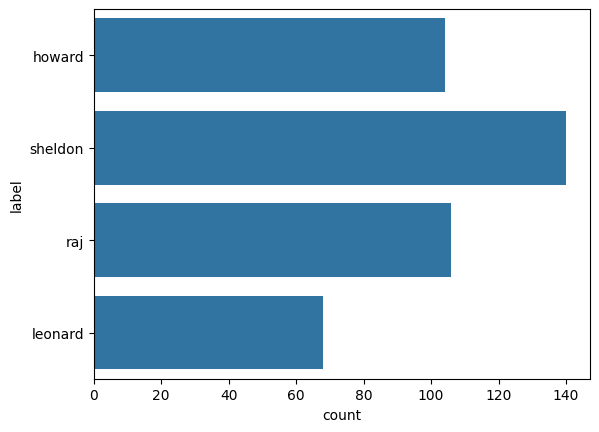

In [39]:
sns.countplot(train['label'])

<Axes: xlabel='count', ylabel='label'>

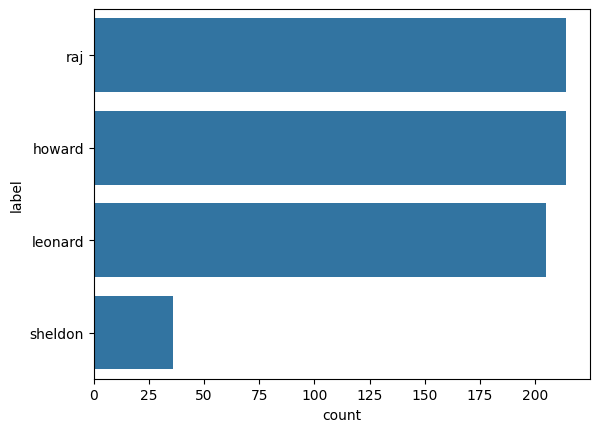

In [40]:
sns.countplot(test['label'])

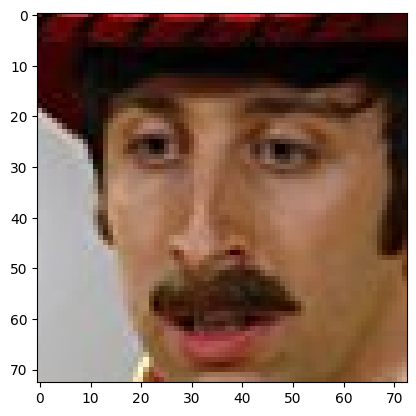

In [41]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img)

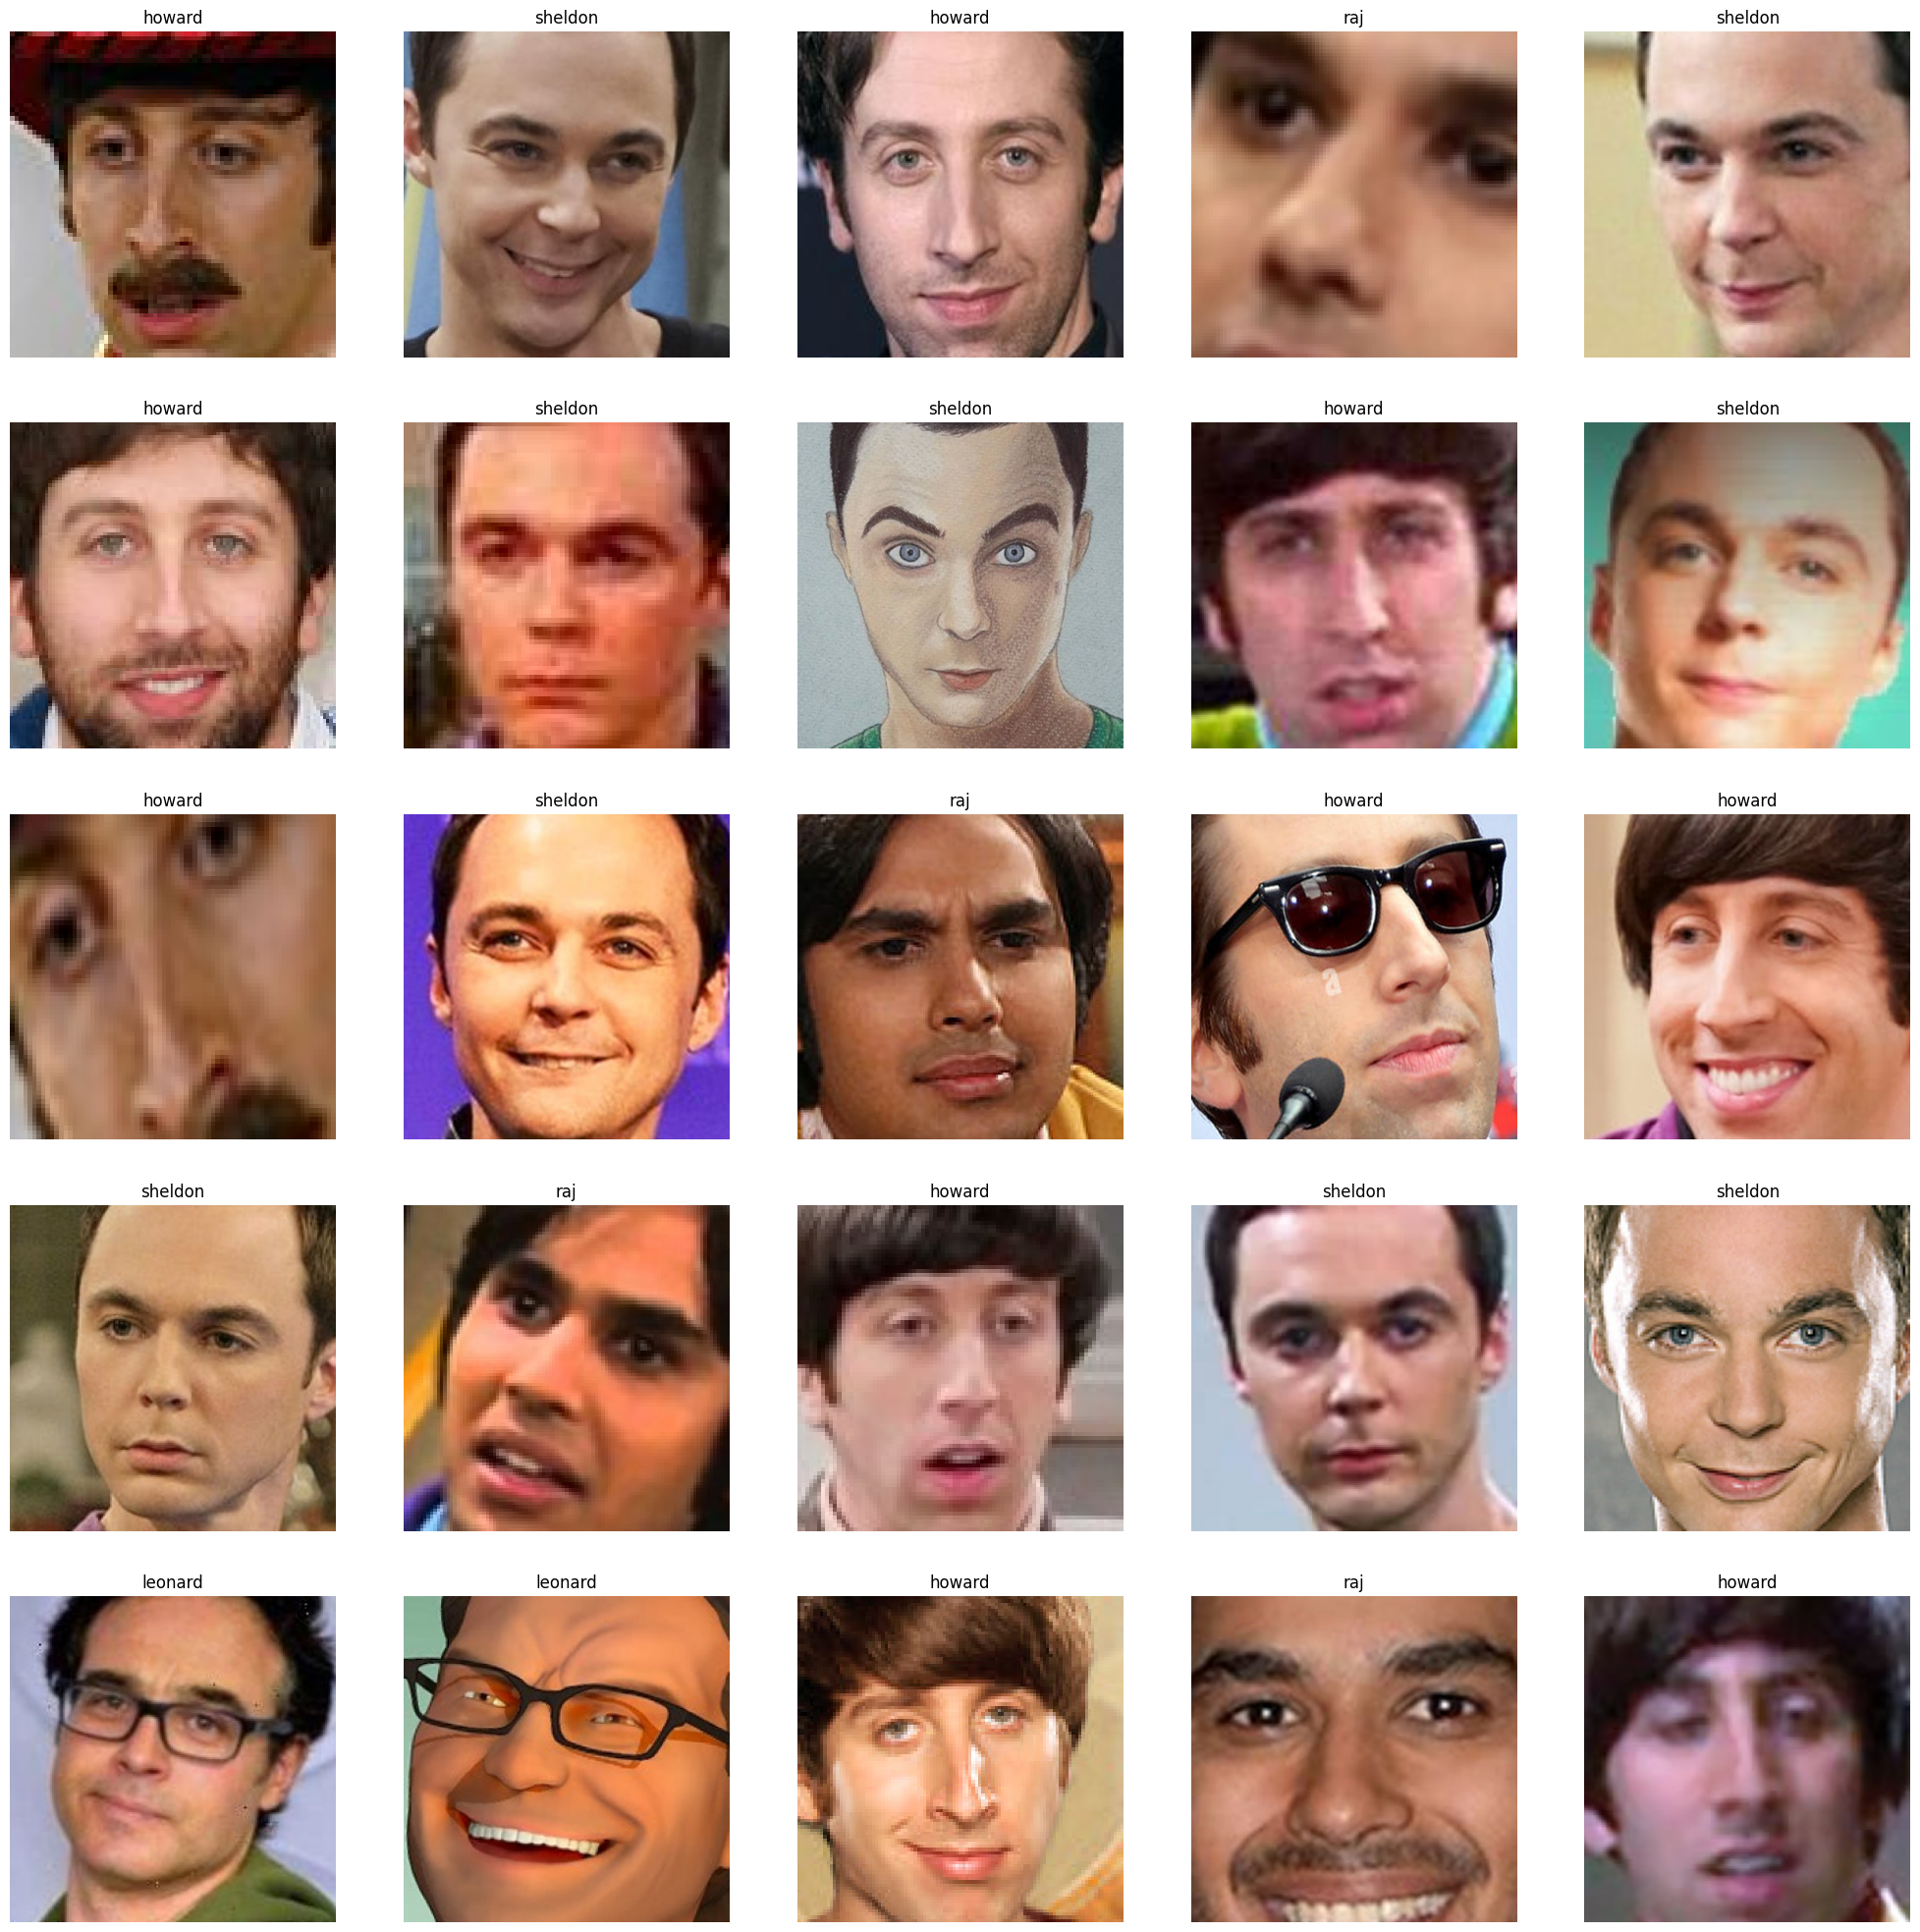

In [42]:
# Display as imagens do datase em grid
plt.figure(figsize=(25, 25))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Função de extração das imagens dos atores

A função extract_actors(images) tem como objetivo carregar imagens, convertê-las em um formato numérico adequado para aprendizado de máquina e, em seguida, armazená-las em um formato específico.

**Inicialização:**

def extract_actors(images): : Esta linha define uma função chamada extract_actors que recebe uma lista de caminhos de imagem (imagens) como entrada.
actors = []: Uma lista vazia chamada actors é criada para armazenar as imagens processadas.
Carregamento e processamento de imagens:

for image in tqdm(images):: Este loop itera por cada caminho de imagem na lista de imagens usando tqdm, que fornece uma barra de progresso.
img = cv2.imread(image): Esta linha provavelmente tenta ler a imagem usando OpenCV (cv2), mas é imediatamente substituída pela próxima linha.
img = Image.open(image): Esta linha abre a imagem usando a biblioteca PIL (Pillow).
img = np.array(img): A imagem é convertida em uma matriz NumPy, essencialmente transformando-a em uma matriz de valores de pixel.
actors.append(img): A representação da matriz NumPy da imagem é adicionada à lista de atores.
Remodelagem da matriz:

actors = np.array(actors): A lista de atores, agora contendo todas as matrizes de imagens, é convertida em uma matriz NumPy.
actors = actors.reshape(len(actors), 48, 48, 1): Esta é uma etapa crucial para o aprendizado profundo. Ele remodela a matriz de atores para ter dimensões adequadas para uma Rede Neural Convolucional (CNN).
len(actors): Representa o número de imagens.
48, 48: Especifica que cada imagem deve ser redimensionada para 48x48 pixels, um tamanho comum em reconhecimento de imagem.
1: Indica que as imagens são em tons de cinza (canal de cor única). Se as imagens fossem RGB, esse valor seria 3.
Retornando o resultado:

return actors: A função retorna o array actors final contendo os dados de imagem processados ​​e remodelados.
Em resumo: A função extract_actors pega uma lista de caminhos de imagem, carrega cada imagem, converte-os em arrays NumPy e os remodela em um formato adequado para uso em uma CNN, normalmente para tarefas de reconhecimento ou classificação de imagem.

In [43]:
def extract_actors(images):
  actors = []
  for image in tqdm(images):
    img = load_img(image, target_size=(48,48), color_mode='rgb')
    img = np.array(img)
    actors.append(img)

  actors = np.array(actors)

  return actors

In [44]:
train_actors = extract_actors(train['image'])

  0%|          | 0/418 [00:00<?, ?it/s]

In [45]:
test_actors = extract_actors(test['image'])

  0%|          | 0/669 [00:00<?, ?it/s]

## Normalização das imagens

In [46]:
x_train = train_actors/255.0
x_test = test_actors/255.0

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [48]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [49]:
print("Shape x_train:", x_train.shape)
print("Shape y_train:", y_train.shape)

print("Shape x_test:", x_test.shape)
print("Shape y_test:", y_test.shape)

Shape x_train: (418, 48, 48, 3)
Shape y_train: (418, 4)
Shape x_test: (669, 48, 48, 3)
Shape y_test: (669, 4)


## Calculo dos pesos

Como temos o número de imagens é desbalanceada precisamos calcular os pesos par que seja adicionado ao modelo de treinamento.

In [50]:
# Converte one-hot para índices inteiros (ex: [0, 2, 1, 3])
y_train_indices = np.argmax(y_train, axis=1)  # Chave aqui!

# Calcula os pesos
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_indices),  # Classes únicas (ex: [0, 1, 2, 3])
    y=y_train_indices                    # Labels como inteiros
)
class_weights = dict(enumerate(class_weights))

In [ ]:
!pip install Augmentor

## Aumento do número de imagens

In [51]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [55]:
import Augmentor
import shutil

minority_classes = ['leonard', 'howard', 'raj']

for class_name in minority_classes:
    # Diretório de treino (origem das imagens)
    input_dir = f"/content/drive/MyDrive/actors_bbt_split/train/{class_name}"

    # Diretório de teste (destino final)
    # output_dir = f"/content/drive/MyDrive/actors_bbt_split/test/{class_name}"

    # Criar pipeline com o diretório de treino
    pipeline = Augmentor.Pipeline(input_dir)

    # Aplicar aumentos
    pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

    # Gerar imagens (salva automaticamente em input_dir/output)
    pipeline.sample(400)

    # Mover as imagens geradas para o diretório de teste
    temp_dir = os.path.join(input_dir, "output")
    for img in os.listdir(temp_dir):
        src = os.path.join(temp_dir, img)
        dst = os.path.join(output_dir, img)
        shutil.move(src, dst)

    # Remover pasta temporária vazia
    os.rmdir(temp_dir)

Initialised with 68 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/leonard/output.

Processing <PIL.Image.Image image mode=RGB size=87x87 at 0x7F1D64612F90>: 100%|██████████| 400/400 [00:12<00:00, 31.61 Samples/s]


Initialised with 104 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/howard/output.

Processing <PIL.Image.Image image mode=RGB size=453x453 at 0x7F1D6403BB10>: 100%|██████████| 400/400 [00:18<00:00, 21.95 Samples/s]


Initialised with 106 image(s) found.
Output directory set to /content/drive/MyDrive/actors_bbt_split/train/raj/output.

Processing <PIL.Image.Image image mode=RGB size=106x106 at 0x7F1D5E089C90>: 100%|██████████| 400/400 [00:11<00:00, 34.78 Samples/s]


In [56]:
!tree /content/drive/MyDrive/actors_bbt_split/ -d

/content/drive/MyDrive/actors_bbt_split/
├── test
│   ├── howard
│   ├── leonard
│   ├── raj
│   └── sheldon
└── train
    ├── howard
    ├── leonard
    ├── raj
    └── sheldon

10 directories


In [57]:
train_actors = extract_actors(train['image'])
x_train = train_actors / 255.0

  0%|          | 0/418 [00:00<?, ?it/s]

In [58]:
print("Número total de imagens de treino após augmentation:", len(train['image']))

Número total de imagens de treino após augmentation: 418


## Distribuição das imagens em cada diretório

In [59]:
import numpy as np
print("Contagem de amostras por classe:", np.bincount(y_train_indices))

Contagem de amostras por classe: [104  68 106 140]


## Rede aplicada para o treinamento da rede neural

In [60]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Treinamento do modelo

In [61]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Re-initialize the ImageDataGenerator to ensure it's in the current scope
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Treino
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

Epoch 1/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2826 - loss: 1.3961

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.2784 - loss: 1.3963 - val_accuracy: 0.1764 - val_loss: 1.3870
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2907 - loss: 1.3825

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2887 - loss: 1.3824 - val_accuracy: 0.2810 - val_loss: 1.3581
Epoch 3/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1987 - loss: 1.4077

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2029 - loss: 1.4043 - val_accuracy: 0.4021 - val_loss: 1.3340
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3754 - loss: 1.3056

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3745 - loss: 1.3063 - val_accuracy: 0.5022 - val_loss: 1.2748
Epoch 5/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4566 - loss: 1.2225

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4555 - loss: 1.2195 - val_accuracy: 0.4723 - val_loss: 1.1699
Epoch 6/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4770 - loss: 1.1999

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4835 - loss: 1.1866 - val_accuracy: 0.5306 - val_loss: 1.0651
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6494 - loss: 0.9249 - val_accuracy: 0.3886 - val_loss: 1.3760
Epoch 8/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4651 - loss: 1.1327

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4725 - loss: 1.1252 - val_accuracy: 0.6338 - val_loss: 0.9616
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6442 - loss: 0.9433

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6438 - loss: 0.9427 - val_accuracy: 0.6308 - val_loss: 0.9397
Epoch 10/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6430 - loss: 0.9072

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6423 - loss: 0.9080 - val_accuracy: 0.7235 - val_loss: 0.7701
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6774 - loss: 0.8519 - val_accuracy: 0.6218 - val_loss: 0.8945
Epoch 12/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7097 - loss: 0.7342

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7126 - loss: 0.7324 - val_accuracy: 0.7280 - val_loss: 0.7055
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7151 - loss: 0.7363 - val_accuracy: 0.7175 - val_loss: 0.7463
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7238 - loss: 0.6488 - val_accuracy: 0.7055 - val_loss: 0.7833
Epoch 15/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7115 - loss: 0.7323

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7131 - loss: 0.7292 - val_accuracy: 0.7265 - val_loss: 0.6894
Epoch 16/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7581 - loss: 0.5838 - val_accuracy: 0.7055 - val_loss: 0.6925
Epoch 17/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7970 - loss: 0.5408 - val_accuracy: 0.7250 - val_loss: 0.7351
Epoch 18/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7782 - loss: 0.6150 - val_accuracy: 0.7280 - val_loss: 0.7310
Epoch 19/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8377 - loss: 0.4685

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8336 - loss: 0.4765 - val_accuracy: 0.7399 - val_loss: 0.6500
Epoch 20/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8275 - loss: 0.4202

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8258 - loss: 0.4260 - val_accuracy: 0.7429 - val_loss: 0.6281
Epoch 21/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8155 - loss: 0.4530 - val_accuracy: 0.7459 - val_loss: 0.7342
Epoch 22/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8033 - loss: 0.5107 - val_accuracy: 0.7339 - val_loss: 0.7036
Epoch 23/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7806 - loss: 0.6051

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7813 - loss: 0.6014 - val_accuracy: 0.7623 - val_loss: 0.6269
Epoch 24/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8221 - loss: 0.4467 - val_accuracy: 0.7593 - val_loss: 0.6283
Epoch 25/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8363 - loss: 0.4142

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8357 - loss: 0.4205 - val_accuracy: 0.7892 - val_loss: 0.5517
Epoch 26/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8647 - loss: 0.4398

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8611 - loss: 0.4469 - val_accuracy: 0.7997 - val_loss: 0.5251
Epoch 27/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8788 - loss: 0.3515

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8779 - loss: 0.3586 - val_accuracy: 0.7907 - val_loss: 0.5112
Epoch 28/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8495 - loss: 0.3753 - val_accuracy: 0.7578 - val_loss: 0.6559
Epoch 29/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8210 - loss: 0.4837 - val_accuracy: 0.7862 - val_loss: 0.6391
Epoch 30/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8830 - loss: 0.2861 - val_accuracy: 0.7937 - val_loss: 0.5314
Epoch 31/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8541 - loss: 0.3832 - val_accuracy: 0.7803 - val_loss: 0.5266
Epoch 32/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8538 - loss: 0.4064 - val_accuracy: 0.8072 - val_loss: 0.5388
Epoch 33/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8522 - loss: 0.4137

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8521 - loss: 0.4138 - val_accuracy: 0.8206 - val_loss: 0.4680
Epoch 34/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8872 - loss: 0.3305

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8839 - loss: 0.3354 - val_accuracy: 0.8161 - val_loss: 0.4495
Epoch 35/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8633 - loss: 0.3457 - val_accuracy: 0.8311 - val_loss: 0.5001
Epoch 36/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8741 - loss: 0.3325 - val_accuracy: 0.8102 - val_loss: 0.5055
Epoch 37/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8763 - loss: 0.3113 - val_accuracy: 0.8012 - val_loss: 0.4851
Epoch 38/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9223 - loss: 0.2424

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9208 - loss: 0.2450 - val_accuracy: 0.8416 - val_loss: 0.4165
Epoch 39/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8449 - loss: 0.3573 - val_accuracy: 0.7429 - val_loss: 0.7036
Epoch 40/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8914 - loss: 0.2843 - val_accuracy: 0.8176 - val_loss: 0.4729
Epoch 41/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9296 - loss: 0.2532 - val_accuracy: 0.8117 - val_loss: 0.5373
Epoch 42/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9098 - loss: 0.2386 - val_accuracy: 0.8191 - val_loss: 0.5374
Epoch 43/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8740 - loss: 0.3456

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8734 - loss: 0.3468 - val_accuracy: 0.8580 - val_loss: 0.3547
Epoch 44/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8852 - loss: 0.2865 - val_accuracy: 0.8191 - val_loss: 0.4807
Epoch 45/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9119 - loss: 0.2344 - val_accuracy: 0.8087 - val_loss: 0.5273
Epoch 46/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9373 - loss: 0.1935 - val_accuracy: 0.8625 - val_loss: 0.4188
Epoch 47/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9199 - loss: 0.2686 - val_accuracy: 0.7967 - val_loss: 0.5679
Epoch 48/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8870 - loss: 0.2470 - val_accuracy: 0.8490 - val_loss: 0.4340
Epoch 49/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8944 - loss: 0.2985 - val_accuracy: 0.8475 - val_loss: 0.4472
Epoch 50/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8867 - loss: 0.3019 - val_accuracy: 0.8401 

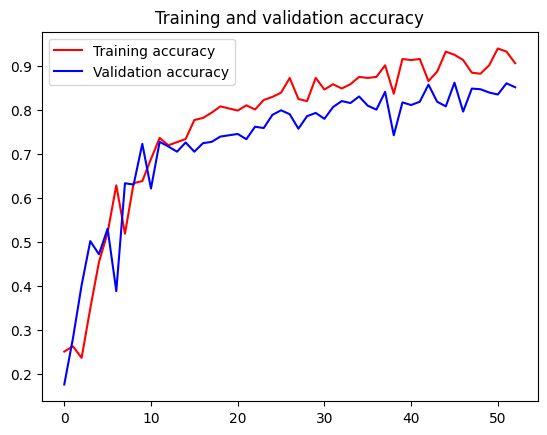

<Figure size 640x480 with 0 Axes>

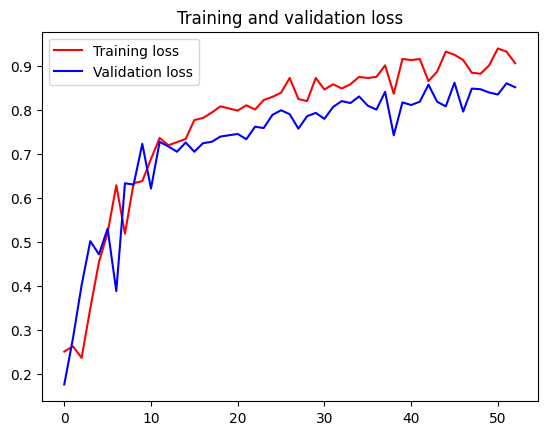

<Figure size 640x480 with 0 Axes>

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Original output sheldon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted output sheldon


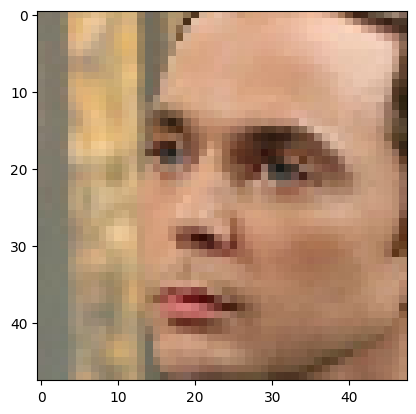

In [66]:
image_index = random.randint(0, len(test))
print("Original output", test['label'][image_index])
pred = model.predict(test_actors[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted output", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48, 3))

## Conclusão

Mesmo com um número reduzido de imagens e mesmo que aplicado o aumento de imagens o modelo foi bem treinado. A acurácia chegou a 0.9078. Depois de treinado o modelo foi aplicado em uma imagem aleatória e os resultados foram satisfatóros.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


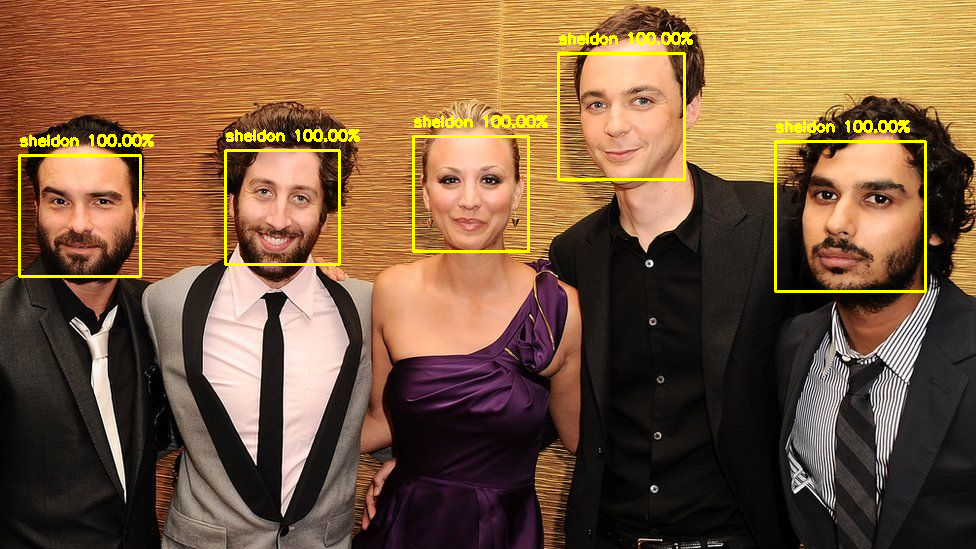

In [71]:
# Importações necessárias
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow  # Adicione esta linha

# 1. Carregar o modelo treinado e configurações
model = load_model('best_model.h5')  # Seu modelo treinado
class_labels = ['howard', 'leonard', 'raj', 'sheldon']  # Lista de classes na ordem usada no treino
class_colors = {  # Cores diferentes para cada classe
    'howard': (0, 255, 0),    # Verde
    'leonard': (0, 0, 255),   # Vermelho
    'raj': (255, 0, 0),       # Azul
    'sheldon': (0, 255, 255)  # Amarelo
}

# 2. Função para pré-processamento da imagem
def preprocess_face(face_roi):
    face = cv2.resize(face_roi, (48, 48))  # Redimensionar para o tamanho que o modelo espera
    face = img_to_array(face)             # Converter para array
    face = np.expand_dims(face, axis=0)   # Adicionar dimensão do batch
    face = face / 255.0                   # Normalização
    return face

# 3. Carregar detector de faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 4. Carregar imagem de teste
image = cv2.imread('/content/test_image.jpg')  # Substituir pelo seu caminho
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Converter para escala de cinza

# 5. Detectar rostos na imagem
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(48, 48)
)

# 6. Processar cada rosto detectado
for (x, y, w, h) in faces:
    # Extrair ROI (Região de Interesse) do rosto
    face_roi = image[y:y+h, x:x+w]

    # Pré-processamento para o modelo
    processed_face = preprocess_face(face_roi)

    # Fazer a predição
    preds = model.predict(processed_face)[0]

    # Obter label e confiança
    predicted_idx = np.argmax(preds)
    label = class_labels[predicted_idx]
    confidence = preds[predicted_idx] * 100

    # 7. Desenhar bounding box e label
    # Caixa retangular
    cv2.rectangle(image,
                 (x, y),          # Ponto superior esquerdo
                 (x+w, y+h),      # Ponto inferior direito
                 class_colors[label],
                 2)

    # Texto com label e confiança
    text = f"{label} {confidence:.2f}%"
    cv2.putText(image, text,
               (x, y-10),        # Posição do texto
               cv2.FONT_HERSHEY_SIMPLEX,
               0.5,
               class_colors[label],
               2)

# 8. Exibir resultado
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()